In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## The data set - Energy consumption for selected buildings in Bristol

Data taken from:
https://data.gov.uk/dataset/1b41eb5c-4b7a-4f60-ae0f-3a78c73953bf/energy-consumption-for-selected-bristol-buildings-from-smart-meters-by-half-hour

Published by:
    Bristol City Council 
Last updated:
    13 March 2014 
Topic:
    Environment
Licence:
    Open Government Licence 

Summary

Energy consumption, Gas and Electricity, for selected Bristol buildings from smart meters by half hour.


In [20]:
d1 = pd.read_csv('datasets/Building2Gas.csv')
d2 = pd.read_csv('datasets/Building3Gas.csv')
d3 = pd.read_csv('datasets/Building4Gas.csv')
d4 = pd.read_csv('datasets/Building5Gas.csv')

In [64]:
data = (pd.concat([d1,d2,d3,d4],ignore_index=True)
            .drop(['Utility','Unit','Meter no.','Date'],axis=1)
            .rename(columns={'Building':'target'})
       )
d=dict(zip(np.unique(data['target']),range(len(np.unique(data['target'])))))
data['target']=data['target'].apply(lambda x: d[x])

data.sample(5)

,target,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,04:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00
598,1,66.0,55.0,44.0,22.0,44.0,22.0,33.0,0.0,11.0,...,55.0,55.0,33.0,0.0,33.0,0.0,11.0,44.0,22.0,55.0
1402,3,13.2,9.9,7.7,9.9,8.8,9.9,8.8,8.8,9.9,...,6.6,5.5,5.5,9.9,4.4,2.2,3.3,4.4,6.6,5.5
1415,3,14.3,8.8,12.1,13.2,9.9,8.8,9.9,15.4,8.8,...,7.7,8.8,7.7,6.6,5.5,3.3,7.7,8.8,4.4,4.4
1210,3,1.1,0.0,1.1,0.0,0.0,1.1,0.0,1.1,0.0,...,0.0,0.0,1.1,0.0,1.1,0.0,0.0,0.0,1.1,0.0
354,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [65]:
X = data[data.columns[1:]]
y = data['target']
print('X:',X.shape,'y:',y.shape)

X: (1444, 48) y (1444,)


(array([ 693596.   ,  693596.125,  693596.25 ,  693596.375,  693596.5  ,
         693596.625,  693596.75 ,  693596.875,  693597.   ]),
 <a list of 9 Text xticklabel objects>)

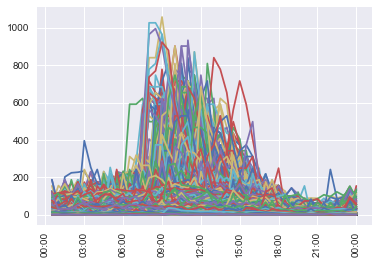

In [113]:
from datetime import datetime
import time
import matplotlib.dates as mdates

t = pd.Series(X.T.index).apply(lambda x: datetime.strptime(x,"%H:%M") if len(x)<6 else datetime.strptime('1900-01-02 00:00',"%Y-%m-%d %H:%M"))

ax = plt.subplot(111)
ax.plot(t,X.T)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
plt.xticks(rotation=90)

(array([ 693596.        ,  693596.04166667,  693596.08333333,
         693596.125     ,  693596.16666667,  693596.20833333,
         693596.25      ,  693596.29166667,  693596.33333333,
         693596.375     ,  693596.41666667,  693596.45833333,
         693596.5       ,  693596.54166667,  693596.58333333,
         693596.625     ,  693596.66666667,  693596.70833333,
         693596.75      ,  693596.79166667,  693596.83333333,
         693596.875     ,  693596.91666667,  693596.95833333,
         693597.        ,  693597.04166667]),
 <a list of 26 Text xticklabel objects>)

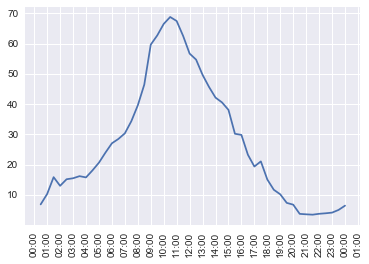

In [130]:
ax = plt.subplot(111)
ax.plot(t,X.T.mean(axis=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=90)

## Extracting features from time series - kNN with Sklearn

In [142]:
Xf = pd.DataFrame(data = X.T.describe().T,index=X.index)
Xf = Xf.drop(['count'],axis=1)
Xf.head()

,mean,std,min,25%,50%,75%,max
0,0.648542,4.493228,0.0,0.0,0.00,0.0000,31.13
1,5.836875,12.279004,0.0,0.0,0.00,0.0000,31.13
2,158.892708,207.612316,0.0,0.0,31.13,217.9100,622.60
3,112.197708,162.676419,0.0,0.0,31.13,163.4325,684.86
4,64.205625,112.407166,0.0,0.0,31.13,70.0425,591.47


In [146]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV

x_train,x_test,y_train,y_test=train_test_split(Xf,y,test_size=0.2,stratify=y,random_state=23)

param={'n_neighbors':[2,4,6]}
clf = GridSearchCV(KNeighborsClassifier(),param,cv=5)
clf.fit(x_train, y_train)
y_true,y_pred=y_test,clf.predict(x_test)
print(clf.best_params_)
print(classification_report(y_true,y_pred))

{'n_neighbors': 6}
             precision    recall  f1-score   support

          0       0.93      0.60      0.73        72
          1       0.80      0.62      0.70        73
          2       0.56      0.89      0.68        72
          3       0.93      0.93      0.93        72

avg / total       0.81      0.76      0.76       289



## Whole time series - kNN with DTW